In [14]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataframe

In [ ]:
df_merged = pd.read_csv("data/df_merged.csv")

# Create the class for epsilon greedy

In [27]:
import random

class MovieRecommender:
    def __init__(self, df, epsilon=1.0, decay=True):
        """
        df: DataFrame containing at least ['MovieID', 'Rating']
        epsilon: initial exploration rate (usually 1 to start with full exploration)
        decay: if True, applies a decay schedule
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay = decay
        self.t = 0

        # Estimated mean rewards initialized at 0.0
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        # Counter for the number of times each movie was selected
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        # Dictionnaire des ratings pour chaque film
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()
        
        # Calculer la récompense maximale par movie pour le regret
        self.optimal_reward_per_movie = {m: max(ratings) for m, ratings in self.ratings_dict.items()}
        self.optimal_reward = max(max(ratings) for ratings in self.ratings_dict.values())
        # Pour regret cumulatif
        self.cum_regret = []

    def select_movie(self):
        """Action selection using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            # Exploration: choose a movie uniformly at random
            return random.choice(self.movie_ids)
        else:
            # Exploitation: choose the movie with the highest empirical mean reward
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Simulate a reward by sampling a real rating from the dataset"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of the empirical mean reward"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Executes one full round of the bandit algorithm"""
        self.t += 1

        # Decay epsilon over time
        if self.decay:
            self.epsilon = self.epsilon_0 * (self.t ** (-1/3))

        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        # Calcul du regret pour cette étape
        # Ici, on prend le max de tous les films pour l'instant
        
        regret = self.optimal_reward - reward
        if len(self.cum_regret) == 0:
            self.cum_regret.append(regret)
        else:
            self.cum_regret.append(self.cum_regret[-1] + regret)

        return movie, reward

    def best_movie(self):
        """Returns the movie ID with the highest estimated mean reward"""
        return max(self.q_values, key=self.q_values.get)


# Test with 100000 iterations

In [28]:
# What is the best movies after T steps?

recommender = MovieRecommender(df_merged, epsilon=1.0, decay=True)

T = 2000
for _ in range(T):
    recommender.step()

best_movie = recommender.best_movie()
title = df_merged.loc[
    df_merged["MovieID"] == best_movie, 
    "Title"
].iloc[0]
print("The best movie is", title, "with estimated mean reward", recommender.q_values[best_movie])



The best movie is Bittersweet Motel with estimated mean reward 5.0


# We will study for each film the number of times it had been chosen, the mean awards

In [29]:
movie_ids = list(recommender.q_values.keys())

df_stats = pd.DataFrame({
    "MovieID": movie_ids,
    "Attempts": [recommender.attempts[mid] for mid in movie_ids],
    "AverageReward": [recommender.q_values[mid] for mid in movie_ids]
})

df_stats["Title"] = df_stats["MovieID"].map(
    dict(zip(df_merged["MovieID"], df_merged["Title"]))
)


# Sort by number of attempts
df_stats = df_stats.sort_values(by="Attempts", ascending=False)

print(df_stats.head(20))  # top 20 most attempted movies

      MovieID  Attempts  AverageReward  \
3635     3881       822       5.000000   
843       904       797       4.475533   
542       556        46       4.173913   
1772     1952        21       4.000000   
3332     3569        15       4.000000   
1297     1396        10       4.000000   
1179     1271         7       4.428571   
2478     2681         5       4.400000   
3138     3367         5       3.800000   
1720     1900         4       4.250000   
899       960         4       3.500000   
479       493         4       3.500000   
2753     2964         4       4.250000   
2823     3037         3       4.333333   
92         95         3       2.666667   
3084     3310         3       3.666667   
2761     2972         3       3.333333   
3216     3448         3       4.000000   
156       162         3       4.000000   
1453     1584         3       4.000000   

                                            Title  
3635                            Bittersweet Motel  
843          

# Cumulative regret in function of iterations

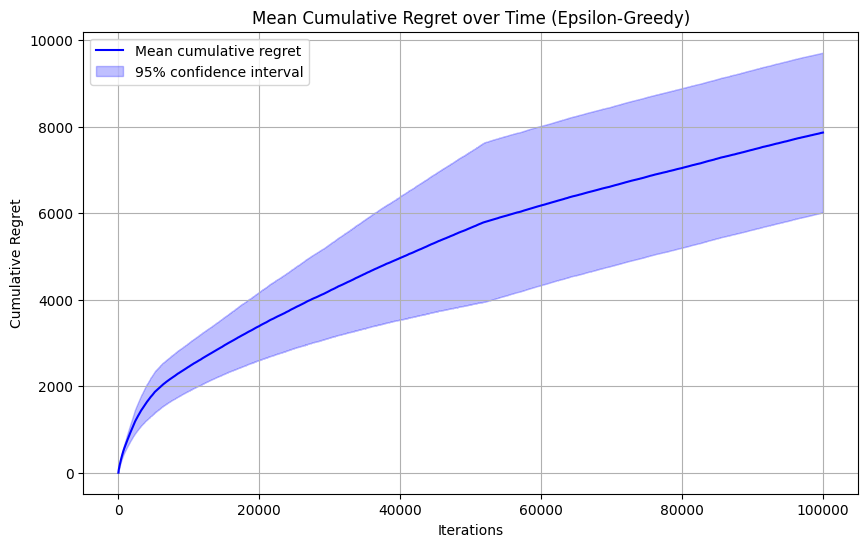

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# number of independent runs
N_RUNS = 20

# number of iterations per run
T = 100000
# Store cumulative regret for all runs
all_cumulative_regrets = np.zeros((N_RUNS, T))

# Calculate the best true average reward per movie
true_rewards = df_merged.groupby("MovieID")["Rating"].mean()
mu_star = true_rewards.max() 

for run in range(N_RUNS):
    # Initialize
    recommender = MovieRecommender(df_merged, epsilon=1.0, decay=True)
    
    for t in range(T):
        recommender.step()
        
        all_cumulative_regrets[run, t] = recommender.cum_regret[-1]
mean_cumulative_regret = all_cumulative_regrets.mean(axis=0)
std_cumulative_regret = all_cumulative_regrets.std(axis=0)
confidence_interval = 1.96 * std_cumulative_regret / np.sqrt(N_RUNS)


plt.figure(figsize=(10,6))
plt.plot(mean_cumulative_regret, color='blue', label="Mean cumulative regret")
plt.fill_between(
    range(T),
    mean_cumulative_regret - confidence_interval,
    mean_cumulative_regret + confidence_interval,
    color='blue',
    alpha=0.25,
    label="95% confidence interval"
)
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Mean Cumulative Regret over Time (Epsilon-Greedy)")
plt.legend()
plt.grid(True)
plt.show()


# Effect of epsilon on the cumulative regret 
We will now adapt the class to study the effect of the value and the decay of epsilon through t on the cumulatitive regret

In [ ]:
import random

class MovieRecommender:
    def __init__(self, df, epsilon=1.0, decay=True, decay_type='decay_optimal'):
        """
        df: DataFrame containing at least ['MovieID', 'Rating']
        epsilon: initial exploration rate
        decay: if True, applies a decay schedule
        decay_type: 'decay_fast', 'decay_optimal', or 'constant'
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay = decay
        self.t = 0
        self.decay_type = decay_type

        # Estimated mean rewards initialized at 0.0
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        # Ratings par film
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()
        
        # Regret calculation
        self.optimal_mean = df.groupby('MovieID')['Rating'].mean().max()
        self.cum_regret = []  
        self.optimal_reward = max([max(ratings) for ratings in self.ratings_dict.values()])

    def select_movie(self):
        """Epsilon-greedy selection"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        else:
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Simulate a reward by sampling a real rating from the dataset"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of estimated mean reward"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Execute one iteration and update cumulative regret"""
        self.t += 1

        # Update epsilon according to decay strategy
        if self.decay:
            if self.decay_type == 'decay_fast':
                self.epsilon = self.epsilon_0 / self.t
            elif self.decay_type == 'decay_optimal':
                self.epsilon = self.epsilon_0 * self.t ** (-1/3)
            else:
                self.epsilon = self.epsilon_0

        # Select movie and get reward
        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)
        
        # Update cumulative regret
        instant_regret = self.optimal_reward - reward
        if self.cum_regret:
            self.cum_regret.append(self.cum_regret[-1] + instant_regret)
        else:
            self.cum_regret.append(instant_regret)

        return movie, reward

    def best_movie(self):
        """Returns the movie ID with the highest estimated mean reward"""
        return max(self.q_values, key=self.q_values.get)


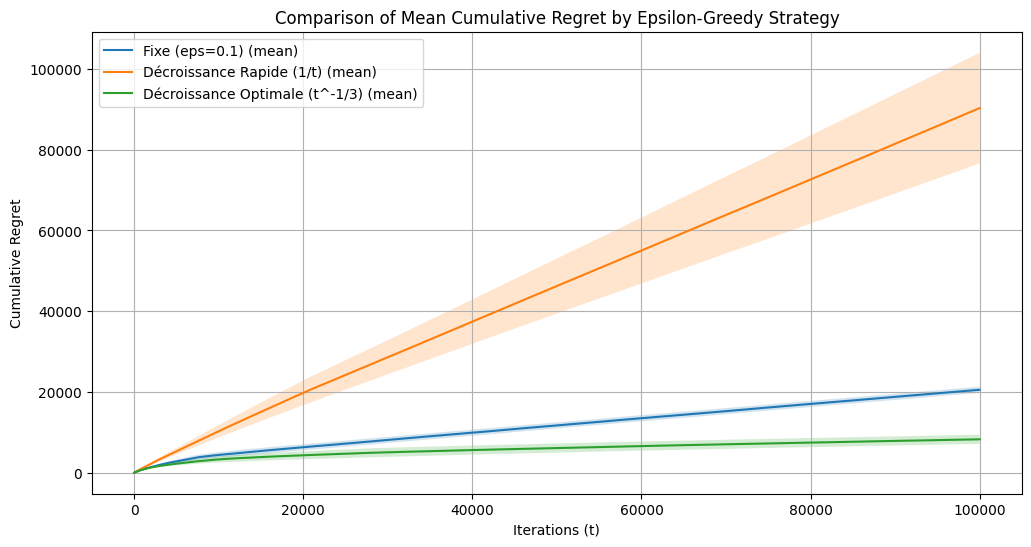

In [ ]:

# Compute true mean reward per movie
true_means = df_merged.groupby("MovieID")["Rating"].mean().to_dict()
mu_star = max(true_means.values())  # best real mean

# strategies to compare
strategies = [
    {'label': 'Fixe (eps=0.1)', 'init': 0.1, 'type': 'constant'},
    {'label': 'Décroissance Rapide (1/t)', 'init': 1.0, 'type': 'decay_fast'},
    {'label': 'Décroissance Optimale (t^-1/3)', 'init': 1.0, 'type': 'decay_optimal'}
]

T = 100000      # number of iterations per run
N_RUNS = 20    # number of independent runs

plt.figure(figsize=(12, 6))

for strat in strategies:
    
    all_cumulative_regrets = np.zeros((N_RUNS, T))
    
    for run in range(N_RUNS):
        recommender = MovieRecommender(
            df_merged,
            epsilon=strat['init'],
            decay=True,
            decay_type=strat['type']
        )

        for t in range(T):
            movie_chosen, reward = recommender.step()
            all_cumulative_regrets[run, t] = recommender.cum_regret[-1]
    

    mean_regret = all_cumulative_regrets.mean(axis=0)
    std_regret = all_cumulative_regrets.std(axis=0)
    
    confidence_interval = 1.96 * std_regret / np.sqrt(N_RUNS)
 
    plt.plot(mean_regret, label=f"{strat['label']} (mean)")
    
    plt.fill_between(
        range(T),
        mean_regret - confidence_interval,
        mean_regret + confidence_interval,
        alpha=0.2
    )

plt.xlabel('Iterations (t)')
plt.ylabel('Cumulative Regret')
plt.title("Comparison of Mean Cumulative Regret by Epsilon-Greedy Strategy")
plt.legend()
plt.grid(True)
plt.show()



# Effect of the initial value of epsilon with a decay in t^{-1/3}

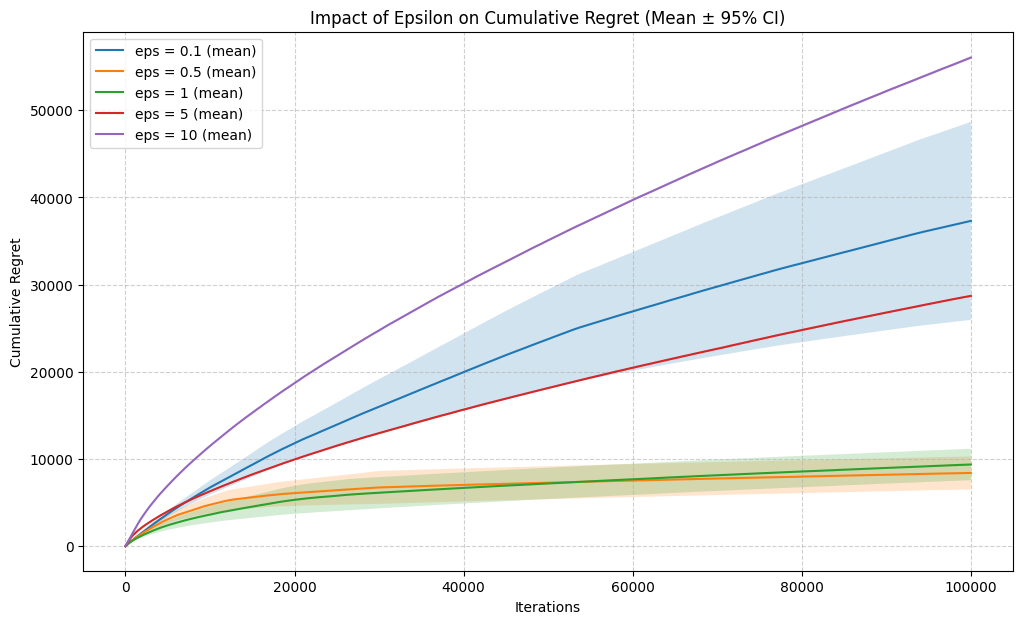

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# list of epsilon values to test
epsilon_values = [0.1, 0.5, 1, 5, 10]
# number of independent runs
N_RUNS = 20
# number of iterations per run
T = 100000

plt.figure(figsize=(12, 7))

for eps in epsilon_values:
    

    all_cumulative_regrets = np.zeros((N_RUNS, T))
    
    for run in range(N_RUNS):
 
        recommender = MovieRecommender(
            df_merged,
            epsilon=eps,
            decay=True,
            decay_type='decay_optimal'  
        )

        for t in range(T):
            recommender.step()
            all_cumulative_regrets[run, t] = recommender.cum_regret[-1]
    
    mean_regret = all_cumulative_regrets.mean(axis=0)
    std_regret = all_cumulative_regrets.std(axis=0)

    confidence_interval = 1.96 * std_regret / np.sqrt(N_RUNS)
    
    plt.plot(mean_regret, label=f"eps = {eps} (mean)")
    
    plt.fill_between(
        range(T),
        mean_regret - confidence_interval,
        mean_regret + confidence_interval,
        alpha=0.2
    )

plt.title("Impact of Epsilon on Cumulative Regret (Mean ± 95% CI)")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
